In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Working with DataLoader & Dataset class in PyTorch

* ## Build Dataset class & instantiate loader

In [2]:
# Create dataset class

class MyDataset(Dataset):
    
    # Overwrite __init__
    def __init__(self):
        
        # Download the data:
        url = r'https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv'
        
        colnames = ['times_preg', 
            'glucose_concent', 
            'blood_press', 
            'fold_thick',
            'insulin',
            'bmi',
            'pedigree_func',
            'age',
            'target']
        
        data = pd.read_csv(url, 
                   comment = '#', 
                   header  = None,
                   names   = colnames)
        
        # Define basics:
        self.len = data.shape[0]
        self.X   = torch.Tensor(data.drop('target', axis = 1).values)
        self.y   = torch.Tensor(data.target.values).view(self.len, 1)
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    # Overwrite len()
    def __len__(self):
        return self.len

In [3]:
# Instantiate dataset
dataset = MyDataset()

In [4]:
# Create DataLoader
train_loader = DataLoader(dataset = dataset,
                          batch_size = 32,
                          shuffle = True,
                          num_workers = 0)

In [5]:
# This is cool :)
dataset[9]

(tensor([  8.0000, 125.0000,  96.0000,   0.0000,   0.0000,   0.0000,   0.2320,
          54.0000]), tensor([1.]))

In [6]:
dataset.X.shape

torch.Size([768, 8])

* ## Define the model class

In [27]:
class MyModel(torch.nn.Module):
    
    def __init__(self):
        
        super(MyModel, self).__init__()
        
        self.layer_1 = torch.nn.Linear(8, 6)
        self.layer_2 = torch.nn.Linear(6, 4)
        self.layer_3 = torch.nn.Linear(4, 1)
        
        self.relu    = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        
        
    def forward(self, x):
        
        out_1 = self.relu(self.layer_1(x))
        out_2 = self.relu(self.layer_2(out_1))
        out_3 = self.sigmoid(self.layer_3(out_2))
        
        return out_3

In [28]:
# Instatntiate the model
model = MyModel()

In [17]:
# Define loss & optimizer
loss_func = torch.nn.BCELoss(reduction = 'mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0003)

In [18]:
# Capture loss history
history = []

In [19]:
# Define training function
def train_it(model, n_epochs = 500, granularity = 10):
    
    for epoch in range(n_epochs):
        
        if epoch % granularity == 0:
            print(f"Epoch: {epoch:9}")
        
        for i, data in enumerate(train_loader):
            
#             print(f'Batch: {i:08.2f}')
            
            # Get the inputs
            inputs, labels = data
            
            inputs, labels = Variable(inputs), Variable(labels)
            
            y_pred = model(inputs)
            
            loss = loss_func(y_pred, labels) 

            # Reset gradients, perform backprop, perform optimizer step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        history.append(loss) 
        
        if epoch % granularity == 0:
            print(f"Loss: {loss:10.6f}") 
            print('-' * 10)
            

In [20]:
train_it(model, 501, 50)

Epoch:         0
Loss:   3.107102
----------
Epoch:        50
Loss:   0.538146
----------
Epoch:       100
Loss:   0.514239
----------
Epoch:       150
Loss:   0.597138
----------
Epoch:       200
Loss:   0.548940
----------
Epoch:       250
Loss:   0.658546
----------
Epoch:       300
Loss:   0.475449
----------
Epoch:       350
Loss:   0.359029
----------
Epoch:       400
Loss:   0.519803
----------
Epoch:       450
Loss:   0.519673
----------
Epoch:       500
Loss:   0.389948
----------


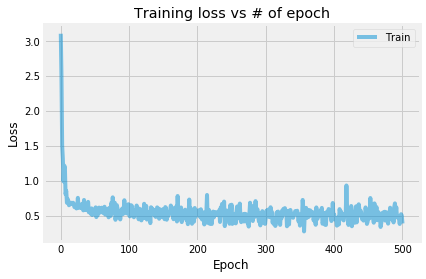

In [21]:
# Plot loss
plt.plot(history, alpha=.5, label='Train')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss vs # of epoch')
plt.show()

In [22]:
# Predict
y_pred = model(dataset.X)

In [24]:
# Examine predictions - accuracy
sum((y_pred > .5).numpy() == dataset.y.numpy()) / len(dataset)

array([0.78255208])